## Cell 0: Download & Unzip Dataset

In [1]:
# ============================== Cell 0: Download & Unzip Dataset ==============================

import os
import shutil
import subprocess
import zipfile
from glob import glob
from tqdm import tqdm

REPO_URL = "https://github.com/EnfangCui/MetroDataset.git"
CLONE_DIR = "MetroDataset"            # default git clone folder name
TARGET_DIR = "MetroDataset-master"    # folder name expected by later cells

def run_cmd(cmd_list):
    try:
        subprocess.run(cmd_list, check=True)
    except FileNotFoundError as e:
        raise RuntimeError("Command not found. Ensure 'git' is installed and on PATH.") from e
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"Command failed: {' '.join(cmd_list)}") from e

def unzip_all(root_dir):
    total_removed = 0
    round_num = 1
    while True:
        zip_paths = glob(os.path.join(root_dir, "**", "*.zip"), recursive=True)
        if not zip_paths:
            break
        print(f"Unzipping round {round_num}: found {len(zip_paths)} zip file(s)")
        for zp in tqdm(zip_paths):
            try:
                with zipfile.ZipFile(zp, "r") as zf:
                    zf.extractall(os.path.dirname(zp))
                os.remove(zp)  # delete the zip after successful extraction
                total_removed += 1
            except zipfile.BadZipFile:
                print(f"Skipping invalid or corrupted zip: {zp}")
        round_num += 1
    print(f"Unzipped and removed {total_removed} zip file(s) in total.")

# 1) Clone the repository if needed
if not os.path.exists(CLONE_DIR) and not os.path.exists(TARGET_DIR):
    print(f"Cloning repository from {REPO_URL} ...")
    run_cmd(["git", "clone", "--depth", "1", REPO_URL, CLONE_DIR])
else:
    print("Repository already present. Skipping clone.")

# 2) Ensure final folder name matches what later cells expect
if os.path.exists(CLONE_DIR) and not os.path.exists(TARGET_DIR):
    print(f"Renaming '{CLONE_DIR}' -> '{TARGET_DIR}'")
    os.rename(CLONE_DIR, TARGET_DIR)
elif os.path.exists(TARGET_DIR):
    print(f"Using existing folder: '{TARGET_DIR}'")
else:
    raise RuntimeError("Unexpected state: clone directory not found.")

# 3) Recursively unzip all .zip files within the dataset and delete the zip archives
unzip_all(TARGET_DIR)

print("\nDone. Dataset is ready at:", os.path.abspath(TARGET_DIR))

Repository already present. Skipping clone.
Using existing folder: 'MetroDataset-master'
Unzipped and removed 0 zip file(s) in total.

Done. Dataset is ready at: d:\coding projects\TDS\KGP\MetroDataset-master


## Cell 1 — Setup & Imports

In [2]:
# ============================== Cell 1: Setup & Imports ==============================

import os
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

warnings.filterwarnings("ignore")
sns.set_theme(context="notebook", style="whitegrid")
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", 100)

## Cell 2 — Configuration

In [3]:
# ============================== Cell 2: Configuration ================================

RAW_DATA_DIR = "./MetroDataset-master"
PROCESSED_DIR = "./Processed_STFT_Transform"

SAMPLING_RATE = 1024
SEGMENT_DURATION = 20
SEGMENT_LENGTH = SAMPLING_RATE * SEGMENT_DURATION

# Overlap/stride (keep as-is to reproduce your results)
STRIDE = int(SEGMENT_LENGTH * 0.2)    # 80% overlap
# STRIDE = int(SEGMENT_LENGTH * 0.4)  # 60% overlap
# STRIDE = int(SEGMENT_LENGTH * 0.5)  # 50% overlap

TRANSFORMS = ["STFT"]  # Only use STFT

# Training
BATCH_SIZE = 8
EPOCHS = 50
LR = 0.001
SEEDS = [100, 500, 750, 1000, 1200]

# Visualization and exports (enabled so folders won't be empty)
SHOW_PLOTS = True
SAVE_PLOTS = True
PLOTS_DIR = "./Reports/plots_cm"

SAVE_RESULTS = True
EXPORT_DIR = "./Reports/exports"

CLASS_NAMES = ["Normal", "Failure"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Cell 3 — Utilities

In [4]:
# ============================== Cell 3: Utilities ===================================

def print_section(title):
    display(HTML(f"<h3 style='margin-top:16px'>{title}</h3>"))

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def load_signal(class_path, axis, mode):
    filename = f"Metro_vibration_v1_{axis}_axis_{mode}.csv"
    filepath = os.path.join(class_path, filename)
    df = pd.read_csv(filepath)
    return df.iloc[:, 1].values  # keep identical behavior

def segment_signals(x, y, z):
    total_samples = len(x)
    segments = []
    for start in range(0, total_samples - SEGMENT_LENGTH + 1, STRIDE):
        segments.append((
            x[start:start + SEGMENT_LENGTH],
            y[start:start + SEGMENT_LENGTH],
            z[start:start + SEGMENT_LENGTH]
        ))
    return segments

def save_npy(data, out_dir, count):
    ensure_dir(out_dir)
    path = os.path.join(out_dir, f"segment_{count:05d}.npy")
    np.save(path, data)

def transform_exists(transform):
    return all(os.path.exists(os.path.join(PROCESSED_DIR, transform, cls))
               for cls in ["Normal", "Failure"])

def plot_confusion_matrix_counts(cm, labels, title, seed=None, transform="STFT"):
    plt.figure(figsize=(5.5, 4.5))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                     xticklabels=labels, yticklabels=labels, cbar=True)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{title} (counts)")
    plt.tight_layout()

    if SAVE_PLOTS:
        ensure_dir(PLOTS_DIR)
        fname = f"{transform}_seed{seed}_cm_counts.png" if seed is not None else f"{transform}_cm_counts.png"
        plt.savefig(os.path.join(PLOTS_DIR, fname), dpi=150, bbox_inches="tight")
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()

## Cell 4 — STFT Preprocessing

In [5]:
# ============================== Cell 4: STFT Preprocessing ==========================

def generate_transforms_if_needed():
    for transform in TRANSFORMS:
        if transform_exists(transform):
            print(f"{transform} already exists. Skipping.")
            continue

        print(f"Generating: {transform}")
        for mode in ["Normal", "Failure"]:
            class_path = os.path.join(RAW_DATA_DIR, mode)
            x = load_signal(class_path, 'x', mode.lower())
            y = load_signal(class_path, 'y', mode.lower())
            z = load_signal(class_path, 'z', mode.lower())

            segments = segment_signals(x, y, z)

            for count, segment in enumerate(tqdm(segments, desc=f"{transform}-{mode}")):
                try:
                    # Keep identical STFT behavior to preserve results
                    def compute_stft(sig):
                        sig_tensor = torch.tensor(sig, dtype=torch.float32, device=DEVICE)
                        stft = torch.stft(sig_tensor, n_fft=256, hop_length=128, return_complex=True)
                        magnitude = torch.abs(stft).cpu().numpy()
                        return magnitude

                    data = np.stack([
                        compute_stft(segment[0]),
                        compute_stft(segment[1]),
                        compute_stft(segment[2])
                    ], axis=-1)

                    save_npy(data, os.path.join(PROCESSED_DIR, transform, mode), count)
                except Exception as e:
                    print(f"Error in {transform} for {mode} segment {count}: {e}")
                    continue

print_section("Preprocessing Check")
generate_transforms_if_needed()
print("Transform folders are ready.")

Generating: STFT


STFT-Failure: 100%|██████████| 1517/1517 [00:04<00:00, 340.34it/s]

Transform folders are ready.


## Cell 5 — Dataset

In [6]:
# ============================== Cell 5: Dataset =====================================

class Metro2DDataset(Dataset):
    def __init__(self, root, transform_type):
        self.samples = []
        self.labels = []
        for label, mode in enumerate(["Normal", "Failure"]):
            dir_path = os.path.join(root, transform_type, mode)
            files = sorted(os.listdir(dir_path))
            for file in files:
                self.samples.append(os.path.join(dir_path, file))
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = np.load(self.samples[idx]).astype(np.float32)  # (H, W, C)
        data = np.transpose(data, (2, 0, 1))  # (C, H, W)
        return torch.tensor(data), torch.tensor(self.labels[idx])

## Cell 6 — Model

In [7]:
# ============================== Cell 6: Model =======================================

class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

## Cell 7 — Model Summary

In [8]:
# ============================== Cell 7: Model Summary ======================

def layer_param_count(module):
    return sum(p.numel() for p in module.parameters())

def is_leaf_module(m):
    return len(list(m.children())) == 0

def summarize_model_tabular(model, input_shape=(3, 129, 161), device=DEVICE):
    model = model.to(device)
    model.eval()

    hooks = []
    records = []

    def register_hooks(module, name):
        if not is_leaf_module(module):
            return
        def hook(module, inp, out):
            if isinstance(out, (list, tuple)):
                out_shape = [tuple(o.shape) for o in out]
            else:
                out_shape = tuple(out.shape)
            records.append({
                "Layer": name,
                "Type": module.__class__.__name__,
                "Output Shape": out_shape,
                "Params": layer_param_count(module)
            })
        hooks.append(module.register_forward_hook(hook))

    for name, module in model.named_modules():
        if name == "":
            continue
        register_hooks(module, name)

    with torch.no_grad():
        dummy = torch.randn(1, *input_shape, device=device)
        _ = model(dummy)

    for h in hooks:
        h.remove()

    df = pd.DataFrame(records)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print_section("Model Architecture (Tabular)")
    display(df.style.format({"Params": "{:,}"}))
    display(pd.DataFrame({
        "Total Parameters": [f"{total_params:,}"],
        "Trainable Parameters": [f"{trainable_params:,}"],
        "Input Shape": [str((1,)+input_shape)],
        "Output Shape": [str(list(model(torch.randn(1, *input_shape, device=device)).shape))]
    }))

## Cell 8 — Training & Evaluation Helpers

In [9]:
# ============================== Cell 8: Train & Eval Helpers ========================

def train_one_epoch(model, dataloader, criterion, optimizer, device=DEVICE):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(len(dataloader), 1)

def evaluate(model, dataloader, criterion, device=DEVICE):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())
            total_loss += loss.item()
    return all_labels, all_preds, total_loss / max(len(dataloader), 1)

## Cell 9 — Run & Report

,"Sample Spectrogram Shape (C,H,W)"
0,"(3, 129, 161)"


,Layer,Type,Output Shape,Params
0,conv.0,Conv2d,"(1, 16, 129, 161)",448
1,conv.1,ReLU,"(1, 16, 129, 161)",0
2,conv.2,MaxPool2d,"(1, 16, 64, 80)",0
3,conv.3,Conv2d,"(1, 32, 64, 80)","4,640"
4,conv.4,ReLU,"(1, 32, 64, 80)",0
5,conv.5,MaxPool2d,"(1, 32, 32, 40)",0
6,conv.6,Conv2d,"(1, 64, 32, 40)","18,496"
7,conv.7,ReLU,"(1, 64, 32, 40)",0
8,conv.8,MaxPool2d,"(1, 64, 16, 20)",0
9,conv.9,Conv2d,"(1, 128, 16, 20)","73,856"


,Total Parameters,Trainable Parameters,Input Shape,Output Shape
0,"105,826","105,826","(1, 3, 129, 161)","[1, 2]"


Epoch 1/50 - Loss: 0.4396
Epoch 2/50 - Loss: 0.3819
Epoch 3/50 - Loss: 0.3298
Epoch 4/50 - Loss: 0.2231
Epoch 5/50 - Loss: 0.1696
Epoch 6/50 - Loss: 0.0966
Epoch 7/50 - Loss: 0.0583
Epoch 8/50 - Loss: 0.0444
Epoch 9/50 - Loss: 0.0640
Epoch 10/50 - Loss: 0.1204
Epoch 11/50 - Loss: 0.0680
Epoch 12/50 - Loss: 0.0414
Epoch 13/50 - Loss: 0.0393
Epoch 14/50 - Loss: 0.0380
Epoch 15/50 - Loss: 0.0643
Epoch 16/50 - Loss: 0.0403
Epoch 17/50 - Loss: 0.0370
Epoch 18/50 - Loss: 0.0876
Epoch 19/50 - Loss: 0.1229
Epoch 20/50 - Loss: 0.0578
Epoch 21/50 - Loss: 0.0604
Epoch 22/50 - Loss: 0.0400
Epoch 23/50 - Loss: 0.0381
Epoch 24/50 - Loss: 0.0343
Epoch 25/50 - Loss: 0.0326
Epoch 26/50 - Loss: 0.0360
Epoch 27/50 - Loss: 0.0305
Epoch 28/50 - Loss: 0.0332
Epoch 29/50 - Loss: 0.0371
Epoch 30/50 - Loss: 0.0386
Epoch 31/50 - Loss: 0.0725
Epoch 32/50 - Loss: 0.0629
Epoch 33/50 - Loss: 0.0482
Epoch 34/50 - Loss: 0.0486
Epoch 35/50 - Loss: 0.0290
Epoch 36/50 - Loss: 0.0302
Epoch 37/50 - Loss: 0.0316
Epoch 38/5

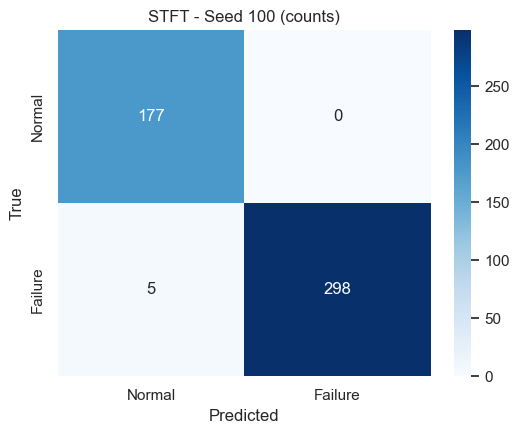

,Accuracy,Loss
0,0.9896,0.0319


,precision,recall,f1-score,support
Normal,0.9725,1.0000,0.9861,177.0000
Failure,1.0000,0.9835,0.9917,303.0000
accuracy,0.9896,0.9896,0.9896,0.9896
macro avg,0.9863,0.9917,0.9889,480.0000
weighted avg,0.9899,0.9896,0.9896,480.0000


Epoch 1/50 - Loss: 0.4900
Epoch 2/50 - Loss: 0.4234
Epoch 3/50 - Loss: 0.3869
Epoch 4/50 - Loss: 0.3533
Epoch 5/50 - Loss: 0.3140
Epoch 6/50 - Loss: 0.2821
Epoch 7/50 - Loss: 0.2570
Epoch 8/50 - Loss: 0.2490
Epoch 9/50 - Loss: 0.2138
Epoch 10/50 - Loss: 0.1772
Epoch 11/50 - Loss: 0.1001
Epoch 12/50 - Loss: 0.0769
Epoch 13/50 - Loss: 0.1163
Epoch 14/50 - Loss: 0.0524
Epoch 15/50 - Loss: 0.0516
Epoch 16/50 - Loss: 0.0622
Epoch 17/50 - Loss: 0.0457
Epoch 18/50 - Loss: 0.0599
Epoch 19/50 - Loss: 0.0413
Epoch 20/50 - Loss: 0.0333
Epoch 21/50 - Loss: 0.0311
Epoch 22/50 - Loss: 0.1695
Epoch 23/50 - Loss: 0.1243
Epoch 24/50 - Loss: 0.0551
Epoch 25/50 - Loss: 0.0360
Epoch 26/50 - Loss: 0.0320
Epoch 27/50 - Loss: 0.0297
Epoch 28/50 - Loss: 0.1112
Epoch 29/50 - Loss: 0.0385
Epoch 30/50 - Loss: 0.0375
Epoch 31/50 - Loss: 0.0299
Epoch 32/50 - Loss: 0.0313
Epoch 33/50 - Loss: 0.0320
Epoch 34/50 - Loss: 0.0330
Epoch 35/50 - Loss: 0.0377
Epoch 36/50 - Loss: 0.0492
Epoch 37/50 - Loss: 0.0289
Epoch 38/5

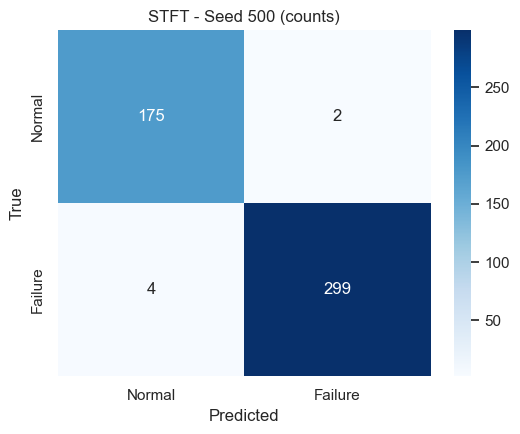

,Accuracy,Loss
0,0.9875,0.0377


,precision,recall,f1-score,support
Normal,0.9777,0.9887,0.9831,177.0000
Failure,0.9934,0.9868,0.9901,303.0000
accuracy,0.9875,0.9875,0.9875,0.9875
macro avg,0.9855,0.9877,0.9866,480.0000
weighted avg,0.9876,0.9875,0.9875,480.0000


Epoch 1/50 - Loss: 0.4757
Epoch 2/50 - Loss: 0.4028
Epoch 3/50 - Loss: 0.3539
Epoch 4/50 - Loss: 0.2989
Epoch 5/50 - Loss: 0.2626
Epoch 6/50 - Loss: 0.1667
Epoch 7/50 - Loss: 0.0885
Epoch 8/50 - Loss: 0.1262
Epoch 9/50 - Loss: 0.0862
Epoch 10/50 - Loss: 0.0500
Epoch 11/50 - Loss: 0.1727
Epoch 12/50 - Loss: 0.0522
Epoch 13/50 - Loss: 0.0405
Epoch 14/50 - Loss: 0.0874
Epoch 15/50 - Loss: 0.0487
Epoch 16/50 - Loss: 0.0456
Epoch 17/50 - Loss: 0.0379
Epoch 18/50 - Loss: 0.0468
Epoch 19/50 - Loss: 0.0382
Epoch 20/50 - Loss: 0.0393
Epoch 21/50 - Loss: 0.0355
Epoch 22/50 - Loss: 0.0333
Epoch 23/50 - Loss: 0.0376
Epoch 24/50 - Loss: 0.1479
Epoch 25/50 - Loss: 0.0609
Epoch 26/50 - Loss: 0.0559
Epoch 27/50 - Loss: 0.0365
Epoch 28/50 - Loss: 0.0342
Epoch 29/50 - Loss: 0.0344
Epoch 30/50 - Loss: 0.0336
Epoch 31/50 - Loss: 0.0318
Epoch 32/50 - Loss: 0.0320
Epoch 33/50 - Loss: 0.2363
Epoch 34/50 - Loss: 0.0597
Epoch 35/50 - Loss: 0.0445
Epoch 36/50 - Loss: 0.0382
Epoch 37/50 - Loss: 0.0308
Epoch 38/5

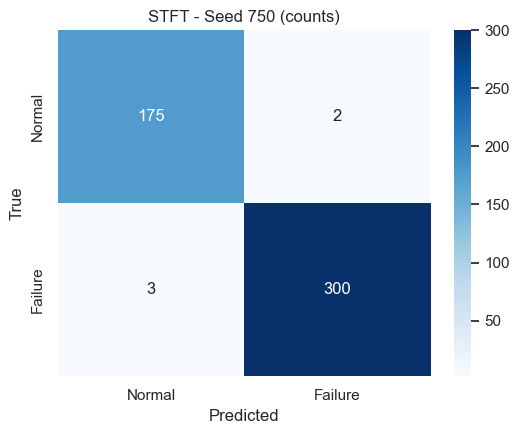

,Accuracy,Loss
0,0.9896,0.0377


,precision,recall,f1-score,support
Normal,0.9831,0.9887,0.9859,177.0000
Failure,0.9934,0.9901,0.9917,303.0000
accuracy,0.9896,0.9896,0.9896,0.9896
macro avg,0.9883,0.9894,0.9888,480.0000
weighted avg,0.9896,0.9896,0.9896,480.0000


Epoch 1/50 - Loss: 0.4819
Epoch 2/50 - Loss: 0.3864
Epoch 3/50 - Loss: 0.3676
Epoch 4/50 - Loss: 0.3881
Epoch 5/50 - Loss: 0.3040
Epoch 6/50 - Loss: 0.2786
Epoch 7/50 - Loss: 0.2352
Epoch 8/50 - Loss: 0.1822
Epoch 9/50 - Loss: 0.1792
Epoch 10/50 - Loss: 0.1174
Epoch 11/50 - Loss: 0.0934
Epoch 12/50 - Loss: 0.0629
Epoch 13/50 - Loss: 0.0678
Epoch 14/50 - Loss: 0.0745
Epoch 15/50 - Loss: 0.0775
Epoch 16/50 - Loss: 0.0955
Epoch 17/50 - Loss: 0.0560
Epoch 18/50 - Loss: 0.0451
Epoch 19/50 - Loss: 0.0542
Epoch 20/50 - Loss: 0.0823
Epoch 21/50 - Loss: 0.0547
Epoch 22/50 - Loss: 0.0390
Epoch 23/50 - Loss: 0.0412
Epoch 24/50 - Loss: 0.0512
Epoch 25/50 - Loss: 0.0335
Epoch 26/50 - Loss: 0.0334
Epoch 27/50 - Loss: 0.0819
Epoch 28/50 - Loss: 0.0600
Epoch 29/50 - Loss: 0.0330
Epoch 30/50 - Loss: 0.0418
Epoch 31/50 - Loss: 0.0423
Epoch 32/50 - Loss: 0.0321
Epoch 33/50 - Loss: 0.0330
Epoch 34/50 - Loss: 0.0453
Epoch 35/50 - Loss: 0.0646
Epoch 36/50 - Loss: 0.0311
Epoch 37/50 - Loss: 0.0315
Epoch 38/5

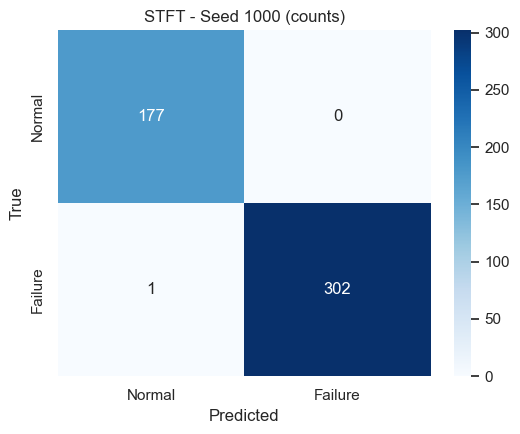

,Accuracy,Loss
0,0.9979,0.0111


,precision,recall,f1-score,support
Normal,0.9944,1.0000,0.9972,177.0000
Failure,1.0000,0.9967,0.9983,303.0000
accuracy,0.9979,0.9979,0.9979,0.9979
macro avg,0.9972,0.9983,0.9978,480.0000
weighted avg,0.9979,0.9979,0.9979,480.0000


Epoch 1/50 - Loss: 0.4816
Epoch 2/50 - Loss: 0.4052
Epoch 3/50 - Loss: 0.3497
Epoch 4/50 - Loss: 0.2956
Epoch 5/50 - Loss: 0.2311
Epoch 6/50 - Loss: 0.1750
Epoch 7/50 - Loss: 0.1207
Epoch 8/50 - Loss: 0.0900
Epoch 9/50 - Loss: 0.0767
Epoch 10/50 - Loss: 0.1023
Epoch 11/50 - Loss: 0.0880
Epoch 12/50 - Loss: 0.0823
Epoch 13/50 - Loss: 0.0456
Epoch 14/50 - Loss: 0.0358
Epoch 15/50 - Loss: 0.0798
Epoch 16/50 - Loss: 0.0583
Epoch 17/50 - Loss: 0.0593
Epoch 18/50 - Loss: 0.0573
Epoch 19/50 - Loss: 0.0562
Epoch 20/50 - Loss: 0.0301
Epoch 21/50 - Loss: 0.0294
Epoch 22/50 - Loss: 0.0338
Epoch 23/50 - Loss: 0.0311
Epoch 24/50 - Loss: 0.0273
Epoch 25/50 - Loss: 0.0304
Epoch 26/50 - Loss: 0.0285
Epoch 27/50 - Loss: 0.0263
Epoch 28/50 - Loss: 0.0294
Epoch 29/50 - Loss: 0.0267
Epoch 30/50 - Loss: 0.0889
Epoch 31/50 - Loss: 0.0625
Epoch 32/50 - Loss: 0.0422
Epoch 33/50 - Loss: 0.0401
Epoch 34/50 - Loss: 0.0459
Epoch 35/50 - Loss: 0.0305
Epoch 36/50 - Loss: 0.0439
Epoch 37/50 - Loss: 0.0789
Epoch 38/5

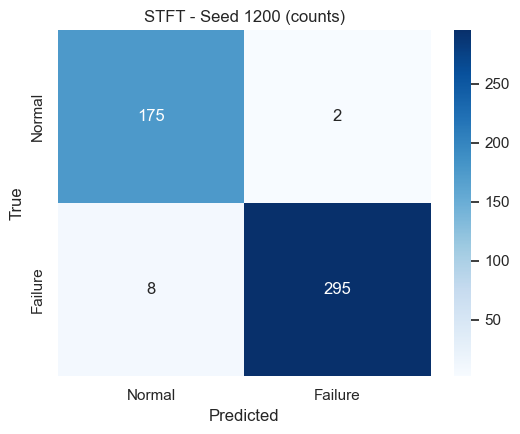

,Accuracy,Loss
0,0.9792,0.047


,precision,recall,f1-score,support
Normal,0.9563,0.9887,0.9722,177.0000
Failure,0.9933,0.9736,0.9833,303.0000
accuracy,0.9792,0.9792,0.9792,0.9792
macro avg,0.9748,0.9811,0.9778,480.0000
weighted avg,0.9796,0.9792,0.9792,480.0000


,Transform,Seed,Accuracy,Loss,TN,FP,FN,TP,Precision_Normal,Recall_Normal,F1_Normal,Precision_Failure,Recall_Failure,F1_Failure,F1_Macro,F1_Weighted,Support_Normal,Support_Failure
0,STFT,100,0.9896,0.0319,177,0,5,298,0.972527,1.000000,0.986072,1.000000,0.983498,0.991681,0.988876,0.989613,177,303
1,STFT,500,0.9875,0.0377,175,2,4,299,0.977654,0.988701,0.983146,0.993355,0.986799,0.990066,0.986606,0.987514,177,303
2,STFT,750,0.9896,0.0377,175,2,3,300,0.983146,0.988701,0.985915,0.993377,0.990099,0.991736,0.988826,0.989589,177,303
3,STFT,1000,0.9979,0.0111,177,0,1,302,0.994382,1.000000,0.997183,1.000000,0.996700,0.998347,0.997765,0.997918,177,303
4,STFT,1200,0.9792,0.0470,175,2,8,295,0.956284,0.988701,0.972222,0.993266,0.973597,0.983333,0.977778,0.979236,177,303


,Transform,Accuracy_Mean,Accuracy_Std,Loss_Mean,Loss_Std
0,STFT,0.988750,0.006686,0.033066,0.013432


,Transform,F1_Macro_Mean,F1_Macro_Std,F1_Weighted_Mean,F1_Weighted_Std,Precision_Normal_Mean,Recall_Normal_Mean,F1_Normal_Mean,Precision_Failure_Mean,Recall_Failure_Mean,F1_Failure_Mean
0,STFT,0.9880,0.0071,0.9888,0.0067,0.9768,0.9932,0.9849,0.9960,0.9861,0.9910


Saved per-seed and summary CSVs to: ./Reports/exports


In [10]:
# ============================== Cell 9: Run & Report ================================

ensure_dir(PLOTS_DIR)
if SAVE_RESULTS:
    ensure_dir(EXPORT_DIR)

all_transform_results = {}

for transform in TRANSFORMS:
    print_section(f"Transform: {transform}")
    
    # Load dataset
    dataset = Metro2DDataset(PROCESSED_DIR, transform)
    if len(dataset) == 0:
        raise ValueError("No processed data found. Ensure preprocessing ran correctly.")

    sample_data, _ = dataset[0]
    C, H, W = sample_data.shape
    display(pd.DataFrame({"Sample Spectrogram Shape (C,H,W)": [str((C, H, W))]}))

    # Model summary (tabular)
    summarize_model_tabular(ShallowCNN(), input_shape=(C, H, W), device=DEVICE)

    results = []

    # Seeded runs
    for seed in SEEDS:
        print_section(f"Seed {seed}")
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        indices = list(range(len(dataset)))
        labels = [dataset.labels[i] for i in indices]
        train_idx, test_idx = train_test_split(
            indices, test_size=0.2, stratify=labels, random_state=seed
        )

        train_ds = torch.utils.data.Subset(dataset, train_idx)
        test_ds  = torch.utils.data.Subset(dataset, test_idx)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

        model = ShallowCNN().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.CrossEntropyLoss()

        # Training
        for epoch in range(1, EPOCHS + 1):
            loss = train_one_epoch(model, train_loader, criterion, optimizer, device=DEVICE)
            print(f"Epoch {epoch}/{EPOCHS} - Loss: {loss:.4f}")

        # Evaluation
        y_true, y_pred, val_loss = evaluate(model, test_loader, criterion, device=DEVICE)
        acc = accuracy_score(y_true, y_pred)

        # Classification report (dict + pretty df)
        report_dict = classification_report(
            y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, digits=4
        )
        report_df = pd.DataFrame(report_dict).T

        # Confusion matrix (counts only)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        plot_confusion_matrix_counts(cm, CLASS_NAMES, title=f"{transform} - Seed {seed}", seed=seed, transform=transform)

        # Record results (original fields + extras)
        results.append({
            "Transform": transform,
            "Seed": seed,
            "Accuracy": acc,
            "Loss": val_loss,
            "TN": cm[0, 0], "FP": cm[0, 1],
            "FN": cm[1, 0], "TP": cm[1, 1],
            "Precision_Normal": report_df.loc["Normal", "precision"],
            "Recall_Normal": report_df.loc["Normal", "recall"],
            "F1_Normal": report_df.loc["Normal", "f1-score"],
            "Precision_Failure": report_df.loc["Failure", "precision"],
            "Recall_Failure": report_df.loc["Failure", "recall"],
            "F1_Failure": report_df.loc["Failure", "f1-score"],
            "F1_Macro": report_df.loc["macro avg", "f1-score"],
            "F1_Weighted": report_df.loc["weighted avg", "f1-score"],
            "Support_Normal": int(report_df.loc["Normal", "support"]),
            "Support_Failure": int(report_df.loc["Failure", "support"]),
        })

        # Display per-seed report (format only numeric cols)
        print_section(f"Per-seed Results — Seed {seed}")
        display(pd.DataFrame({"Accuracy": [acc], "Loss": [val_loss]}))

        report_num_cols = report_df.select_dtypes(include=[np.number]).columns
        rep_styler = report_df.style.format({c: "{:.4f}" for c in report_num_cols})
        rep_styler = rep_styler.background_gradient(cmap="Blues", subset=report_num_cols)
        display(rep_styler)

        # Save per-seed classification report CSV
        if SAVE_RESULTS:
            report_csv = os.path.join(EXPORT_DIR, f"{transform}_seed{seed}_classification_report.csv")
            report_df.to_csv(report_csv, index=True)

    # Aggregate results for this transform
    results_df = pd.DataFrame(results)
    all_transform_results[transform] = results_df

    print_section("Per-seed Results (Full)")
    display(results_df.style.format({
        "Accuracy": "{:.4f}",
        "Loss": "{:.4f}"
    }))

    # Original summary (accuracy/loss)
    summary_df = results_df.groupby("Transform").agg({
        "Accuracy": ["mean", "std"],
        "Loss": ["mean", "std"]
    }).reset_index()
    summary_df.columns = ["Transform", "Accuracy_Mean", "Accuracy_Std", "Loss_Mean", "Loss_Std"]

    print_section("Summary across seeds (Accuracy/Loss)")
    display(summary_df.style.format({
        "Accuracy_Mean": "{:.6f}",
        "Accuracy_Std": "{:.6f}",
        "Loss_Mean": "{:.6f}",
        "Loss_Std": "{:.6f}",
    }).background_gradient(cmap="Greens", subset=["Accuracy_Mean", "Accuracy_Std", "Loss_Mean", "Loss_Std"]))

    # Additional metrics for documentation
    extra_summary = results_df.groupby("Transform").agg({
        "F1_Macro": ["mean", "std"],
        "F1_Weighted": ["mean", "std"],
        "Precision_Normal": ["mean"],
        "Recall_Normal": ["mean"],
        "F1_Normal": ["mean"],
        "Precision_Failure": ["mean"],
        "Recall_Failure": ["mean"],
        "F1_Failure": ["mean"],
    }).reset_index()
    extra_summary.columns = [
        "Transform",
        "F1_Macro_Mean", "F1_Macro_Std",
        "F1_Weighted_Mean", "F1_Weighted_Std",
        "Precision_Normal_Mean",
        "Recall_Normal_Mean",
        "F1_Normal_Mean",
        "Precision_Failure_Mean",
        "Recall_Failure_Mean",
        "F1_Failure_Mean",
    ]

    print_section("Additional Metrics across seeds")
    num_cols = extra_summary.select_dtypes(include=[np.number]).columns
    styler = extra_summary.style.format({c: "{:.4f}" for c in num_cols})
    styler = styler.background_gradient(cmap="Purples", subset=num_cols)
    display(styler)

    # Save per-seed results and summaries
    if SAVE_RESULTS:
        per_seed_csv = os.path.join(EXPORT_DIR, f"{transform}_per_seed_results.csv")
        summary_csv = os.path.join(EXPORT_DIR, f"{transform}_summary_accuracy_loss.csv")
        extra_csv = os.path.join(EXPORT_DIR, f"{transform}_summary_additional_metrics.csv")

        results_df.to_csv(per_seed_csv, index=False)
        summary_df.to_csv(summary_csv, index=False)
        extra_summary.to_csv(extra_csv, index=False)

        print(f"Saved per-seed and summary CSVs to: {EXPORT_DIR}")